# Pipeline for Full-Frame Images
1. Convert the cutout into a lightcurve
2. Make a river plot of the lightcurve and draw a line at the extrema
3. Produce a Lomb-Scargle periodogram and label the harmonics

## Setup and Imports
This cell imports all of the necessary libraries. It also sets up two important variables: `DOWNLOAD_PATH` and `OUTPUT_PATH`, where the cutouts are downloaded and the lightcurves are stored. On Colab, these need to be changed.

In [17]:
import os
import json
import random
import tess_cpm
import numpy as np
import pandas as pd
import lightkurve as lk

import matplotlib
import matplotlib.pyplot as plt

from astropy import table
from astropy import units as u
from astroquery.mast import Tesscut
from astroquery.mast.utils import parse_input_location

from collections import OrderedDict

%matplotlib widget

DOWNLOAD_PATH = "./data"
OUTPUT_PATH = "./lightcurves"
PROCVER = "v0.3.1"

## Downloading and Processing Images

This cell contains the code to download a TESS cutout and process it with `tess-cpm`. The resulting lightcurve is saved to a CSV. The name of the folder in which the lightcurve is saved is its TIC, and the filename is the sector number. 

**`download_object(coordinates=None, size=50, sector=None, inflate=True, objectname=None)`**

Downloads a cutout for a given sector and returns the path. If the cutout has already been downloaded, only returns the path.

**`process_sector(tic, sector)`**

Generates a lightcurve from a full-frame image of the object with the given TIC during the given sector. Saves the lightcurve to a CSV and returns it.

**`load_lc(tic, sector)`**

Loads the lightcurve of the given object and sector. Downloads and processes the FFI for the sector if it does not already exist.


In [18]:
def download_object(coordinates=None, size=50, sector=None, inflate=True, objectname=None):
    print(f"Downloading {objectname}:{sector}")
    coords = parse_input_location(coordinates, objectname)
    ra = f"{coords.ra.value:.6f}"
    matched = [m for m in os.listdir(DOWNLOAD_PATH) if ra in m]
    if len(matched) != 0:
        return [f"{DOWNLOAD_PATH}/{matched[0]}"]
    
    path = Tesscut.download_cutouts(coordinates=coordinates, size=size, sector=sector, path=DOWNLOAD_PATH, inflate=inflate, objectname=objectname)
    return [path[0]["Local Path"]]


def process_sector(tic, sector):
    if os.path.isfile(f"{OUTPUT_PATH}/{tic.split()[1]}/Sector{sector}.csv"):
        return
    
    file = download_object(objectname=tic, sector=sector)
    s = tess_cpm.Source(f"{file[0]}", remove_bad=True)
    
    s.set_aperture(rowlims=[25, 25], collims=[25, 25])
    s.add_cpm_model(exclusion_size=5, n=64, predictor_method="similar_brightness")

    s.set_regs([0.1])
    s.holdout_fit_predict(k=100)

    apt_detrended_flux = s.get_aperture_lc(data_type="cpm_subtracted_flux")

    lc = lk.LightCurve(time=s.time, flux=apt_detrended_flux)

    lc.meta["SECTOR"] = sector
    lc.meta["TESSID"] = tic.split()[1]
    lc.meta["TARGETID"] = tic.split()[1]
    lc.meta["LABEL"] = tic
    lc.meta["OBJECT"] = tic
    lc.meta["PROCVER"] = PROCVER
    lc.meta["AUTHOR"] = "TESS"
    lc.meta["CREATOR"] = "GIDEON"
    
    if not os.path.isdir(f"{OUTPUT_PATH}/{tic.split()[1]}/"):
        os.mkdir(f"{OUTPUT_PATH}/{tic.split()[1]}/")

    with open(f"{OUTPUT_PATH}/{tic.split()[1]}/Sector{sector}.meta", "w") as f:
        f.write(json.dumps(lc.meta))
    
    lc.to_csv(f"{OUTPUT_PATH}/{tic.split()[1]}/Sector{sector}.csv")
    return lc

def load_lc(tic, sector):
    path = f"{OUTPUT_PATH}/{tic.split()[1]}/Sector{sector}.csv"
    if not os.path.isfile(path):
        process_sector(tic, sector)
        
    csv = pd.read_csv(path)
    lc = lk.LightCurve(time=csv.time, flux=csv.flux) 
    with open(f"{OUTPUT_PATH}/{tic.split()[1]}/Sector{sector}.meta") as f:
        lc.meta = json.loads(f.read(), object_pairs_hook=OrderedDict)
    return lc

OrderedDict([('SECTOR', 68), ('TESSID', '300651846'), ('TARGETID', '300651846'), ('LABEL', 'TIC 300651846'), ('OBJECT', 'TIC 300651846'), ('PROCVER', 'v0.3.1'), ('AUTHOR', 'TESS'), ('CREATOR', 'GIDEON')])


## Graphing

These functions produce stylized graphs based on the images Mark showed us. By default, they will fold the lightcurve unless `fold` is set to `False`.

In [26]:
def graph_lc(lc, ylim=None, fold=True):
    if fold:
        lc = lc.fold(lc.to_periodogram().period_at_max_power, epoch_time=lc.time[0])
    lc = lc.remove_outliers(sigma=3)
    
    blc = lc.bin(u.Quantity(25, u.s))
    
    plt.style.use("seaborn-v0_8-notebook")
    fig, ax = plt.subplots()
    
    ax.scatter(lc["time"].value, lc["flux"], 4, "#1f77b4", alpha=0.1)
    ax.scatter(blc["time"].value, blc["flux"], 6, "#1f77b4", alpha=1)
    
    ax.set_title("TIC 300651846")
    ax.set_xlabel("Phase")
    ax.set_ylabel("Flux")

    if ylim is not None:
        ax.set_ylim(-ylim, ylim)

    return ax

In [31]:
def graph_lc_paper(lc, ylim=None, fold=True):
    if fold:
        lc = lc.fold(lc.to_periodogram().period_at_max_power)
    lc = lc.remove_outliers(sigma=3)
    
    blc = lc.bin(u.Quantity(20, u.s))
    
    plt.style.use("seaborn-v0_8-paper")
    fig, ax = plt.subplots()
    
    ax.scatter(lc["time"].value, lc["flux"], 14, "#d3d3d3", alpha=0.7)
    ax.scatter(blc["time"].value, blc["flux"], 20, "#1f77b4", alpha=1)
    
    ax.set_title("TIC 300651846")
    ax.set_xlabel("Phase")
    ax.set_ylabel("Flux")

    if ylim is not None:
        ax.set_ylim(-ylim, ylim)

    return ax

## River Plot

Generates an annotated river plot of the given lightcurve and returns the matplotlib axes.

<Axes: xlabel='Phase', ylabel='Cycle'>

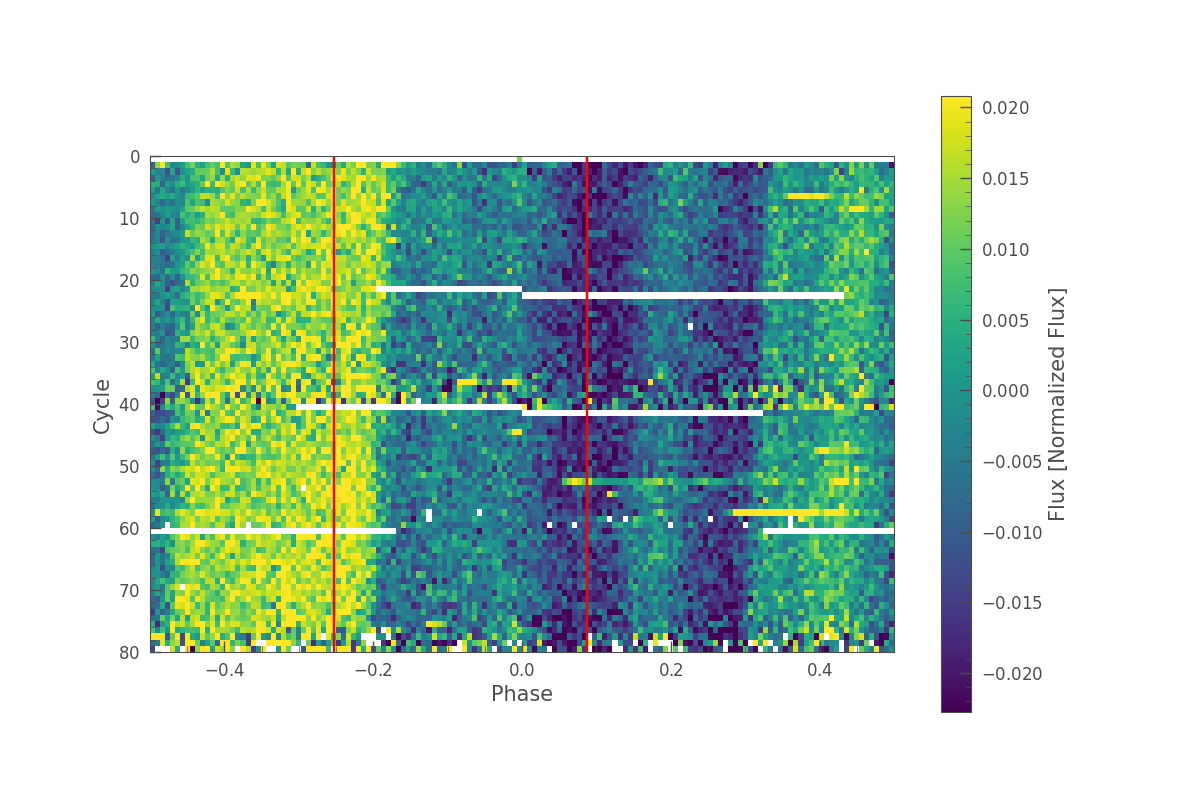

In [32]:
def river_plot(lc):
    lc = lc.fold(lc.to_periodogram().period_at_max_power, epoch_time=lc.time[0])    
    blc = lc.bin(u.Quantity(lc.to_periodogram().period_at_max_power/200, u.d))
    blc.sort("flux")

    min = blc[0][0].value/lc.period.value
    max = blc[-1][0].value/lc.period.value

    ax = lc.plot_river()
    ax.plot([min, min], [0,80], color="red")
    ax.plot([max, max], [0,80], color="red")
    
    return ax